# Visualisations - Analyse des Alertes ANSSI & Enrichissement CVE

## Imports préalables

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import sys

# 1️⃣ Racine = dossier parent de notebooks/
PROJECT_ROOT = Path.cwd().resolve().parent
print("📁 Racine projet :", PROJECT_ROOT)

# 2️⃣ Rendre les modules internes importables
sys.path.insert(0, str(PROJECT_ROOT))

# 3️⃣ Chemins communs
DATA_CSV   = PROJECT_ROOT / "data" / "processed" / "final_dataset.csv"
OUTPUT_DIR = PROJECT_ROOT / "outputs"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)   # ✅ syntaxe correcte

print("CSV présent :", DATA_CSV.exists(), "-", DATA_CSV)

# 4️⃣ Imports internes (désormais visibles)
from src.extract_cves import extract_all_entries
from src.consolidate import build_dataframe

📁 Racine projet : /Users/doryandenis/Desktop/EFREI/Semestre 6/MasterCamp/Atelier DS/AtelierDS_PRJ
CSV présent : True - /Users/doryandenis/Desktop/EFREI/Semestre 6/MasterCamp/Atelier DS/AtelierDS_PRJ/data/processed/final_dataset.csv


## Gravité et risques d'exploitation

### Scatter « CVSS × EPSS »

Nous cherchons à savoir **quelles CVE cumulent sévérité et probabilité**.

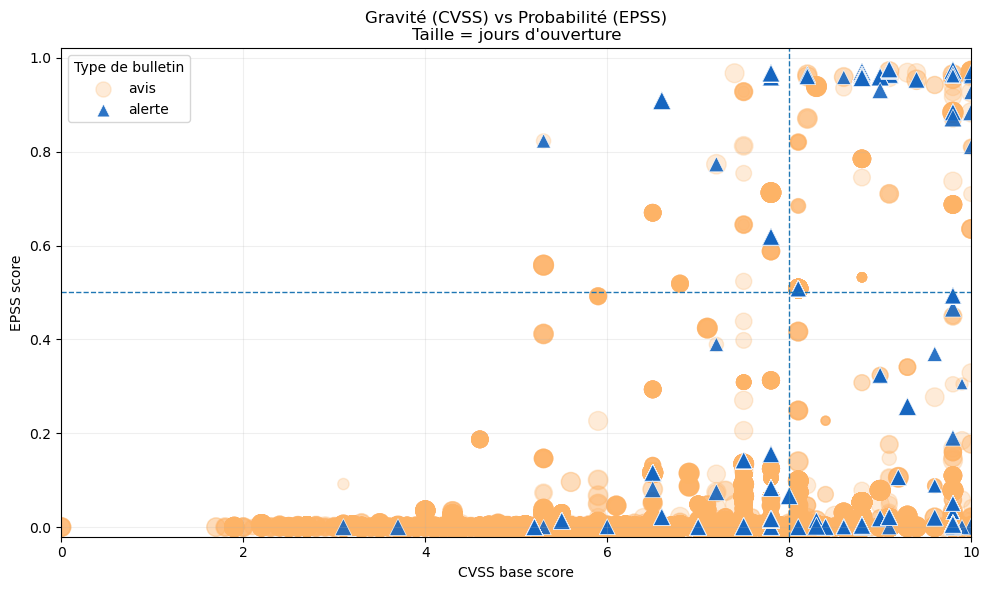

637 urgences enregistrées → /Users/doryandenis/Desktop/EFREI/Semestre 6/MasterCamp/Atelier DS/AtelierDS_PRJ/outputs/urgences_cve.csv


In [9]:
df = pd.read_csv(DATA_CSV, parse_dates=["date", "closed_at"])

# Nettoyage minimal
df = df.dropna(subset=["cvss_score", "epss_score"])
df["cvss_score"] = pd.to_numeric(df["cvss_score"], errors="coerce")
df["epss_score"] = pd.to_numeric(df["epss_score"], errors="coerce")

# Taille des bulles : log(1 + days_open) pour garder lisible
df["size_pt"] = np.log1p(df["days_open"]).fillna(0) * 30

plt.figure(figsize=(10, 6))

# 1️⃣ tracer d’abord les AVIS (orange, transparence)
subset_avis = df[df["type"] == "avis"]
plt.scatter(
    subset_avis["cvss_score"],
    subset_avis["epss_score"],
    s=subset_avis["size_pt"],
    c="#FDB366",                  # orange plus clair
    alpha=0.25,                   # forte transparence
    label="avis",
    marker="o"
)

# 2️⃣ tracer ensuite les ALERTES (bleu, opaques, bord blanc)
subset_alertes = df[df["type"] == "alerte"]
plt.scatter(
    subset_alertes["cvss_score"],
    subset_alertes["epss_score"],
    s=subset_alertes["size_pt"],
    c="#1565C0",                  # bleu plus sombre
    alpha=0.9,
    label="alerte",
    marker="^",                   # triangle
    edgecolors="white",
    linewidths=0.5
)

# Lignes seuils
plt.axvline(8,  linestyle="--", linewidth=1)
plt.axhline(0.5, linestyle="--", linewidth=1)

plt.xlabel("CVSS base score")
plt.ylabel("EPSS score")
plt.title("Gravité (CVSS) vs Probabilité (EPSS)\nTaille = jours d'ouverture")
plt.legend(title="Type de bulletin")
plt.ylim(-0.02, 1.02)
plt.xlim(0, 10)
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()

# Export des urgences (quadrant haut-droit)
urgences = df[(df["cvss_score"] >= 8) & (df["epss_score"] >= 0.5)]
urgences.to_csv(OUTPUT_DIR / "urgences_cve.csv", index=False, encoding="utf-8")
print(f"{len(urgences)} urgences enregistrées → {OUTPUT_DIR / 'urgences_cve.csv'}")